In [1]:
# import necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import networkx as nx

In [2]:
# read training data
df = pd.read_csv('train.csv')

## Inspect the Data

We inspect the train dataset to check the structure of the data and understand the dataset more. We check the summary statistics and look out for possible errors, missing values, outliers or duplicates. We also check the the datatypes of each variable and ensure they are of the proper type. 

In [4]:
df.head()

,language,sentence,n,edgelist,root
0,Japanese,2,23,"[(6, 4), (2, 6), (2, 23), (20, 2), (15, 20), (...",10
1,Japanese,5,18,"[(8, 9), (14, 8), (4, 14), (5, 4), (1, 2), (6,...",10
2,Japanese,8,33,"[(2, 10), (2, 14), (4, 2), (16, 4), (6, 16), (...",3
3,Japanese,11,30,"[(30, 1), (14, 24), (21, 14), (3, 21), (7, 3),...",30
4,Japanese,12,19,"[(19, 13), (16, 19), (2, 16), (4, 10), (4, 15)...",11


In [5]:
# get number of rows and columns
df.shape

(10500, 5)

Target variable: root. 
It says the node that is the root. But to make the task simpler, we will turn it to a binary classification task. Such that, each row takes a node and the target variable will the is_root, where 0 will indicate that the node isn't the root and 1 indicates that it is the root.

This will cause data imbalance in the dataset because most of the classes will be 0. 

In [7]:
# check other variables in the data
df.columns

Index(['language', 'sentence', 'n', 'edgelist', 'root'], dtype='object')

In [8]:
# Basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10500 entries, 0 to 10499
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   language  10500 non-null  object
 1   sentence  10500 non-null  int64 
 2   n         10500 non-null  int64 
 3   edgelist  10500 non-null  object
 4   root      10500 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 410.3+ KB


In [9]:
# Check for missing values
df.isnull().sum()

language    0
sentence    0
n           0
edgelist    0
root        0
dtype: int64

In [10]:
# Check for duplicates
df.duplicated().sum()

0

Training data contains no missing values or duplicated columns, which is good


In [12]:
# check the data types
df.dtypes

language    object
sentence     int64
n            int64
edgelist    object
root         int64
dtype: object

In [13]:
# Confirm the type of object
type(df['edgelist'].iloc[0])

str

Edgelist is of the datatype object (string).

It needs to be converted to a python edgelist which can be used to create the networkx tree

In [15]:
df.describe()

,sentence,n,root
count,10500.000000,10500.000000,10500.000000
mean,494.778000,18.807524,9.844476
std,290.256632,8.190593,7.207740
min,2.000000,3.000000,1.000000
25%,233.500000,13.000000,4.000000
50%,483.000000,18.000000,8.000000
75%,742.250000,23.000000,14.000000
max,995.000000,70.000000,68.000000


There are sentences with 3 nodes (words) and some with as many as 70 nodes. This should be taken into consideration when normalizing. it will be advisable to normalize per sentence coz of this imbalance

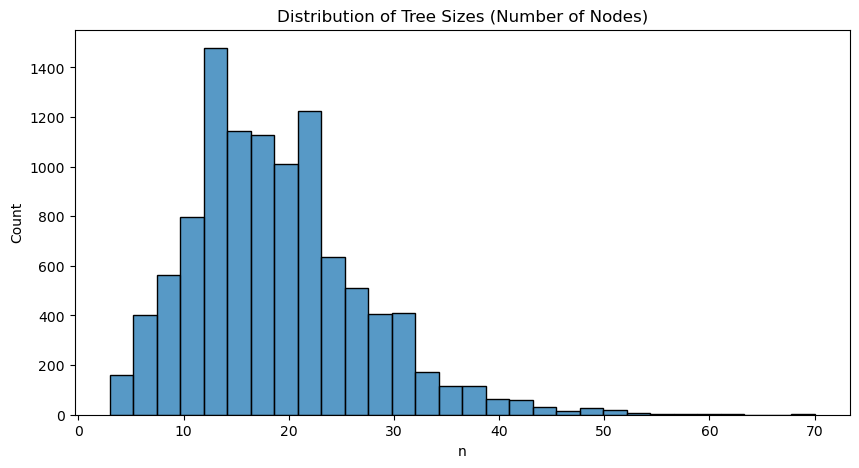

In [17]:
# Sentence length distribution
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='n', bins=30)
plt.title('Distribution of Tree Sizes (Number of Nodes)')
plt.show()

In [18]:
# Language distribution (check number of languages and number of sentences per language)
lang = df['language'].nunique()
print(f'There are {lang} languages. Each language has the following number of sentences:')
df['language'].value_counts()

There are 21 languages. Each language has the following number of sentences:


language
Japanese      500
German        500
Arabic        500
Portuguese    500
Chinese       500
Czech         500
Turkish       500
Thai          500
Polish        500
Korean        500
Icelandic     500
Finnish       500
Spanish       500
Swedish       500
Indonesian    500
Italian       500
French        500
Hindi         500
English       500
Galician      500
Russian       500
Name: count, dtype: int64

count    10500.000000
mean         9.844476
std          7.207740
min          1.000000
25%          4.000000
50%          8.000000
75%         14.000000
max         68.000000
Name: root, dtype: float64


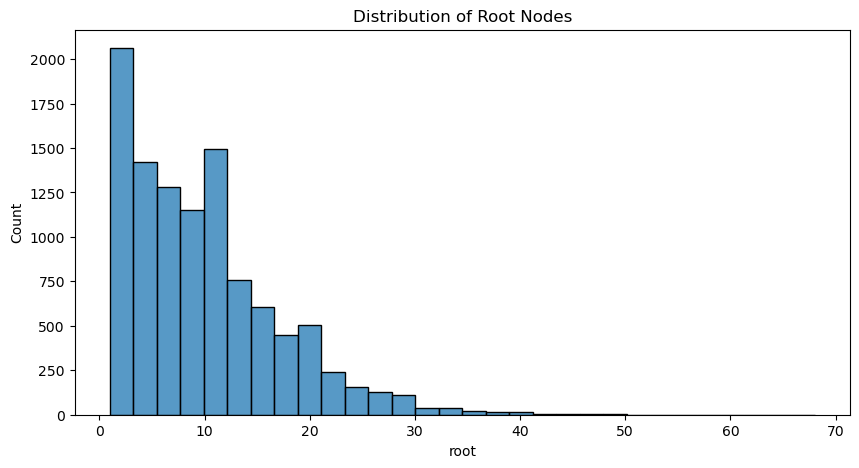

In [19]:
# Root node analysis
print(df['root'].describe())
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='root', bins=30)
plt.title('Distribution of Root Nodes')
plt.show()

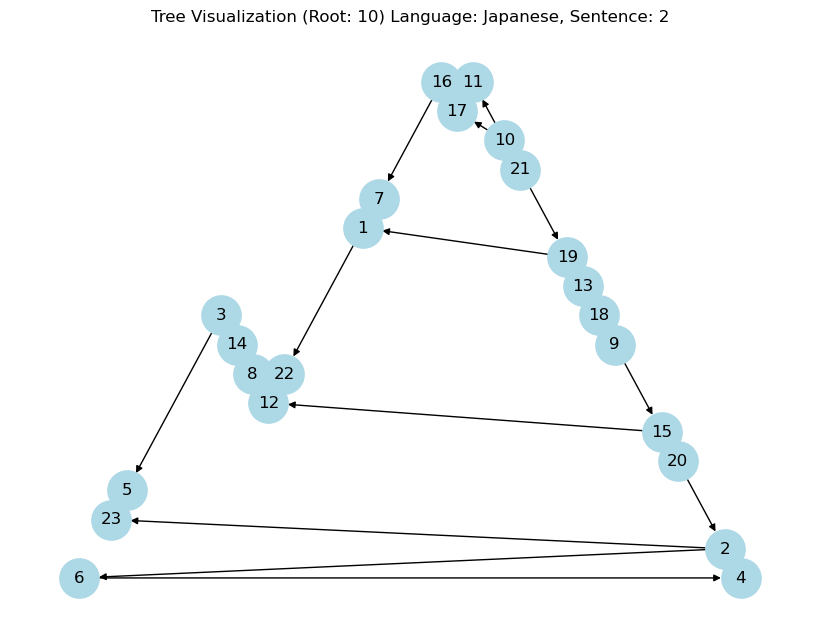

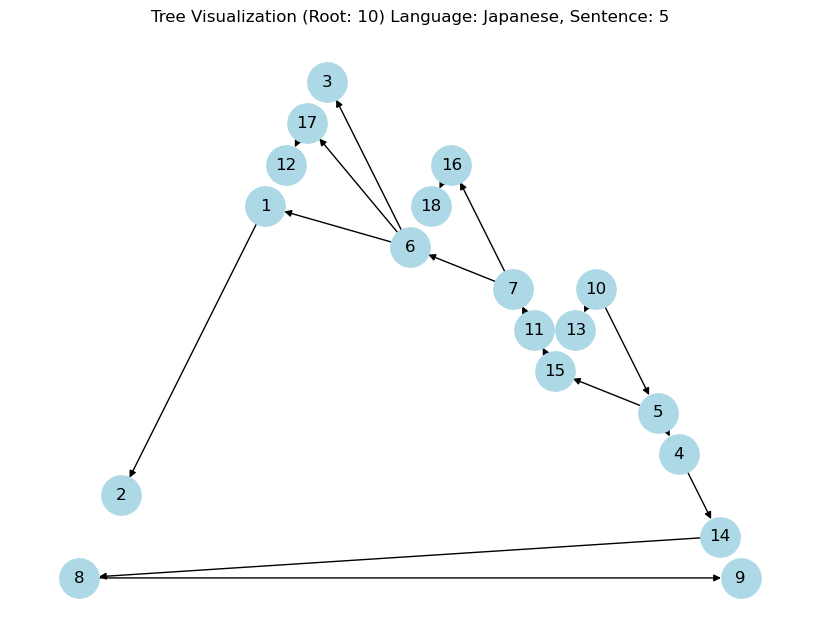

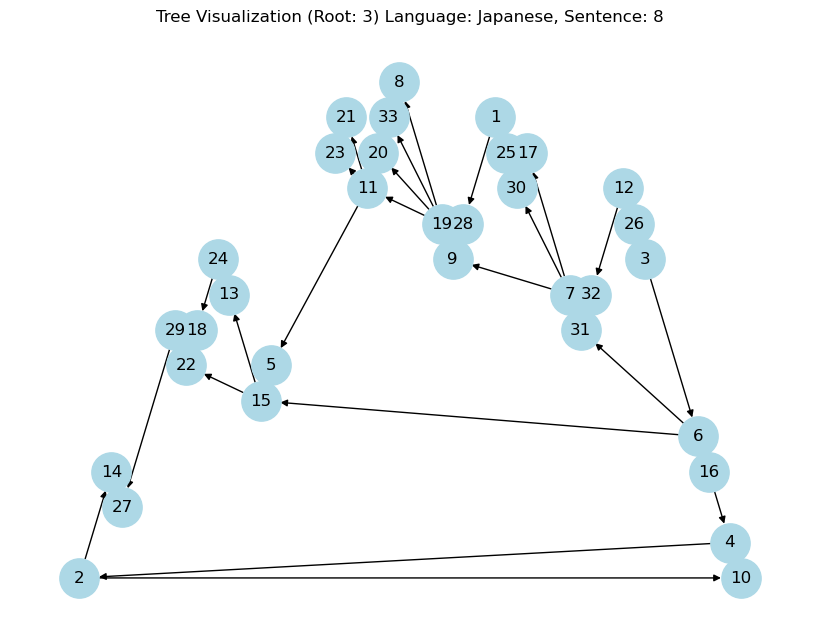

In [20]:
def visualize_tree(edges, root, title=""):
    G = nx.DiGraph()
    G.add_edges_from(edges)
    
    pos = nx.planar_layout(G) if nx.is_planar(G) else nx.spring_layout(G)
    
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, arrows=True, node_size=800, node_color='lightblue')
    plt.title(f"Tree Visualization (Root: {root}) {title}")
    plt.show()

# Visualize first few trees
for i, row in df.head(3).iterrows():
    visualize_tree(ast.literal_eval(row['edgelist']), row['root'], f"Language: {row['language']}, Sentence: {row['sentence']}")

In [86]:
def preprocess(df):
    """
    preprocess dataset to binary classification
    """
    df['edgelist'] = df['edgelist'].apply(ast.literal_eval)

    def centralities(edgelist):
        """
        - edgelist is a list of node pairs e.g. [(7,2),(1,7),(1,9),...]
        - returns a dictionary of vertex -> (centrality values)
        """
        
        T = nx.from_edgelist(edgelist)
        dc = nx.degree_centrality(T)
        cc = nx.harmonic_centrality(T)
        bc = nx.betweenness_centrality(T)
        pc = nx.pagerank(T)
        clc = nx.closeness_centrality(T)
        ec = nx.eigenvector_centrality_numpy(T)
        kz = nx.katz_centrality_numpy(T, alpha=0.005, beta=1.0)
        lc = nx.load_centrality(T)
    
        return {v: (dc[v], cc[v], bc[v], pc[v], clc[v], ec[v], kz[v], lc[v]) for v in T}

    df['centralities'] = df['edgelist'].apply(centralities) 

    def binary_classification(df):
        """
        for each vertex v in tree T:
            generate features from centralities
            set target = 1 if vertex is the root, otherwise it is 0
            add row (features, target) to binary classification training dataset
        """
        
        # Create list to store flattened records
        records = []

        has_root = 'root' in df.columns

        for _, row in df.iterrows():
            for vertex, centrality_metrics in row['centralities'].items():
                record = {
                    'language': row['language'],
                    'sentence': row['sentence'],
                    'n': row['n'],
                    'vertex': vertex,
                    **{f'centrality_{i+1}': metric for i, metric in enumerate(centrality_metrics)}
                }
                if has_root:
                    record['root'] = row['root']
                records.append(record)
        
        # Convert the list of records back to dataframe
        binary_df = pd.DataFrame(records)
        
        # rename centrality metric columns
        binary_df = binary_df.rename(columns={
            'centrality_1': 'degree',
            'centrality_2': 'harmonic',
            'centrality_3': 'betweenness',
            'centrality_4': 'pagerank',
            'centrality_5': 'closeness',
            'centrality_6': 'eigenvector',
            'centrality_7': 'katz',
            'centrality_8': 'load'
        })
        
        # Sort by sentence and vertex 
        binary_df = binary_df.sort_values(['language', 'sentence', 'vertex']).reset_index(drop=True)

        # create is_root target value in train data
        if has_root:
            binary_df['is_root'] = (binary_df['vertex'] == binary_df['root']).astype(int)

        return binary_df

    return binary_classification(df)
    

In [22]:
df = preprocess(df)

# check with project guideline
df[(df['language'] == 'Arabic') & (df['sentence'] == 62)]

,language,sentence,n,root,vertex,degree,harmonic,betweenness,pagerank,closeness,eigenvector,katz,load,is_root
588,Arabic,62,10,5,1,0.111111,3.950000,0.000000,0.058583,0.360000,0.270862,0.314969,0.000000,0
589,Arabic,62,10,5,2,0.222222,5.000000,0.500000,0.104807,0.473684,0.368517,0.316552,0.500000,0
590,Arabic,62,10,5,3,0.111111,3.950000,0.000000,0.058583,0.360000,0.270862,0.314969,0.000000,0
591,Arabic,62,10,5,4,0.111111,3.616667,0.000000,0.060961,0.310345,0.200846,0.314961,0.000000,0
592,Arabic,62,10,5,5,0.333333,5.283333,0.416667,0.162218,0.428571,0.450105,0.318118,0.416667,1
593,Arabic,62,10,5,6,0.111111,3.616667,0.000000,0.060961,0.310345,0.200846,0.314961,0.000000,0
594,Arabic,62,10,5,7,0.222222,4.500000,0.388889,0.108763,0.391304,0.218849,0.316536,0.388889,0
595,Arabic,62,10,5,8,0.222222,3.983333,0.222222,0.115810,0.310345,0.121933,0.316528,0.222222,0
596,Arabic,62,10,5,9,0.111111,3.016667,0.000000,0.064220,0.243243,0.054409,0.314953,0.000000,0
597,Arabic,62,10,5,10,0.444444,6.083333,0.750000,0.205094,0.529412,0.607014,0.319693,0.750000,0


In [23]:
# drop root column
df = df.drop('root', axis=1)

In [24]:
# inspect changes made
df.describe()

,sentence,n,vertex,degree,harmonic,betweenness,pagerank,closeness,eigenvector,katz,load,is_root
count,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000
mean,499.636584,22.374151,11.687076,0.106340,6.590969,0.187322,0.053170,0.245772,0.181116,0.225162,0.187322,0.053170
std,291.353683,8.959233,8.269808,0.078688,2.057981,0.217725,0.036490,0.088976,0.142715,0.049724,0.217725,0.224373
min,2.000000,3.000000,1.000000,0.014493,1.500000,0.000000,0.007699,0.062864,0.000001,0.118939,0.000000,0.000000
25%,238.000000,16.000000,5.000000,0.052632,5.120635,0.000000,0.028860,0.183673,0.066948,0.191554,0.000000,0.000000
50%,491.000000,21.000000,10.000000,0.083333,6.333333,0.105105,0.043185,0.230216,0.148881,0.217238,0.105105,0.000000
75%,736.000000,27.000000,16.000000,0.133333,7.782527,0.341667,0.066175,0.290000,0.258312,0.250142,0.341667,0.000000
max,995.000000,70.000000,70.000000,1.000000,20.078175,1.000000,0.486486,1.000000,0.707107,0.579260,1.000000,1.000000


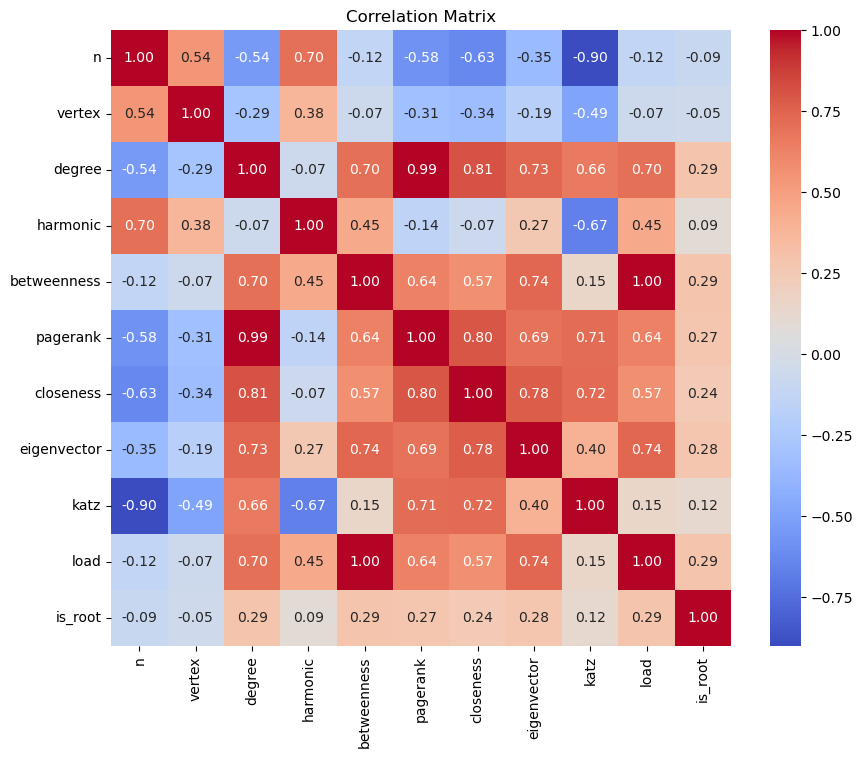

In [25]:
# check the carrelation between features
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop(['sentence', 'language'], axis=1).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

-- remove variables not really correlated with the root

-- drop vertex column, not correlated

In [28]:
# save binary data
df.to_csv('binary_dataset.csv', index=False)

In [29]:
train_df = pd.read_csv('binary_dataset.csv')

In [30]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197479 entries, 0 to 197478
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   language     197479 non-null  object 
 1   sentence     197479 non-null  int64  
 2   n            197479 non-null  int64  
 3   vertex       197479 non-null  int64  
 4   degree       197479 non-null  float64
 5   harmonic     197479 non-null  float64
 6   betweenness  197479 non-null  float64
 7   pagerank     197479 non-null  float64
 8   closeness    197479 non-null  float64
 9   eigenvector  197479 non-null  float64
 10  katz         197479 non-null  float64
 11  load         197479 non-null  float64
 12  is_root      197479 non-null  int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 19.6+ MB


- change language to categorical variable


In [32]:
train_df['language'] = train_df['language'].astype('category')

In [33]:
# get number of rows and columns
train_df.shape

(197479, 13)

In [34]:
# confirm there are no missing values
train_df.isnull().sum()

language       0
sentence       0
n              0
vertex         0
degree         0
harmonic       0
betweenness    0
pagerank       0
closeness      0
eigenvector    0
katz           0
load           0
is_root        0
dtype: int64

In [35]:
# Check for duplicates
train_df.duplicated().sum()

0

In [36]:
# check other variables in the data
df.columns

Index(['language', 'sentence', 'n', 'vertex', 'degree', 'harmonic',
       'betweenness', 'pagerank', 'closeness', 'eigenvector', 'katz', 'load',
       'is_root'],
      dtype='object')

In [37]:
train_df.describe()

,sentence,n,vertex,degree,harmonic,betweenness,pagerank,closeness,eigenvector,katz,load,is_root
count,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000
mean,499.636584,22.374151,11.687076,0.106340,6.590969,0.187322,0.053170,0.245772,0.181116,0.225162,0.187322,0.053170
std,291.353683,8.959233,8.269808,0.078688,2.057981,0.217725,0.036490,0.088976,0.142715,0.049724,0.217725,0.224373
min,2.000000,3.000000,1.000000,0.014493,1.500000,0.000000,0.007699,0.062864,0.000001,0.118939,0.000000,0.000000
25%,238.000000,16.000000,5.000000,0.052632,5.120635,0.000000,0.028860,0.183673,0.066948,0.191554,0.000000,0.000000
50%,491.000000,21.000000,10.000000,0.083333,6.333333,0.105105,0.043185,0.230216,0.148881,0.217238,0.105105,0.000000
75%,736.000000,27.000000,16.000000,0.133333,7.782527,0.341667,0.066175,0.290000,0.258312,0.250142,0.341667,0.000000
max,995.000000,70.000000,70.000000,1.000000,20.078175,1.000000,0.486486,1.000000,0.707107,0.579260,1.000000,1.000000


### Resampling

To estimate the generalization error, we split the data into train and validation set. We will then use a 5-fold cross validation over the train set so we train over a good sample of the data

In [39]:
# separate features and target value
X = train_df.drop('is_root', axis=1)
y = train_df['is_root']


In [40]:
# to avoid data leakage use group split
from sklearn.model_selection import GroupShuffleSplit

# Grouping by sentence ID
groups = train_df['sentence'] 

# Perform group split (80% train, 20% val)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(X, y, groups=groups))

X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

# Verify no sentence appears in both splits
train_sentences = set(groups.iloc[train_idx])
val_sentences = set(groups.iloc[val_idx])
assert train_sentences.isdisjoint(val_sentences), "Data leakage detected!"

### Preprocessing

It will be better to normalize the data since it has different different ranges. we have to do a sentence level normalization because different sentences have different number of nodes

In [42]:
# store sentence ids for per sentence scaling
train_groups, val_groups = groups.iloc[train_idx], groups.iloc[val_idx]

## Note

Group by language then sentence coz per sentence will scale all the sentences from all the languages as one. however for example, Arabic and Turkish trees for the same sentence may have different structures, so we Normalize per-language AND per-sentence by grouping by both language and sentence. treating them as a single group would mix languages during normalization.

*do we use same scaler to fit the test set, or we use independent scalers since we are scaling per sentence*

In [45]:
from sklearn.preprocessing import MinMaxScaler

features = ['degree', 'harmonic', 'betweenness', 'pagerank', 'closeness', 'eigenvector', 'katz', 'load']

def scaling(X):
    """
    Normalize features using MinMaxScaler
    """
    normalized_ft = X.groupby(['language','sentence'])[features].transform(lambda x: MinMaxScaler().fit_transform(x.values.reshape(-1,1)).flatten())
    X_ft= X.drop(features, axis=1) 
    normalized_X = pd.concat([X_ft, normalized_ft], axis=1)
    
    return normalized_X

X_train_normalized = scaling(X_train)
X_val_normalized = scaling(X_val)

C:\Users\nifeo\AppData\Local\Temp\ipykernel_22252\2950020760.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  normalized_ft = X.groupby(['language','sentence'])[features].transform(lambda x: MinMaxScaler().fit_transform(x.values.reshape(-1,1)).flatten())
C:\Users\nifeo\AppData\Local\Temp\ipykernel_22252\2950020760.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  normalized_ft = X.groupby(['language','sentence'])[features].transform(lambda x: MinMaxScaler().fit_transform(x.values.reshape(-1,1)).flatten())


we fit and transform the test set independently because the sentences are different in the two sets, so we can't use the scalers used for train to transform the test set, as we performed a within sentence normalization

We also only performed normalization on the centrality metrics and on the number of nodes n

In [47]:
# drop columns not useful
X_train_normalized = X_train_normalized.drop(['language', 'sentence', 'vertex'], axis=1)
X_val_normalized = X_val_normalized.drop(['language', 'sentence', 'vertex'], axis=1)

In [48]:

import pandas as pd  # For data handling
import numpy as np  # For numerical operations
import networkx as nx  # For graph algorithms
import ast  # To safely parse edge list strings into Python lists
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For advanced plots
from sklearn.model_selection import GroupKFold, GridSearchCV  # Grouped cross-validation and hyperparameter tuning
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
# 7. Cross-validation evaluation
# f1 score . more evaluation metrices
gkf = GroupKFold(n_splits=5)

models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=200, random_state=42),
    'XGBoost': XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=30,
        learning_rate=0.05,
        n_estimators=300,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss'
    )
}
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Cross-validation scores:")
for name, model in models.items():
    accuracies, precisions, recalls, f1s = [], [], [], []
    
    model.fit(X_train_normalized, y_train)
    y_pred = model.predict(X_val_normalized)

    accuracies.append(accuracy_score(y_val, y_pred))
    precisions.append(precision_score(y_val, y_pred, average='macro', zero_division=0))
    recalls.append(recall_score(y_val, y_pred, average='macro', zero_division=0))
    f1s.append(f1_score(y_val, y_pred, average='macro', zero_division=0))

    print(f"\n{name}:")
    print(f"  Accuracy:  {np.mean(accuracies):.4f} +/- {np.std(accuracies):.4f}")
    print(f"  Precision: {np.mean(precisions):.4f} +/- {np.std(precisions):.4f}")
    print(f"  Recall:    {np.mean(recalls):.4f} +/- {np.std(recalls):.4f}")
    print(f"  F1 Score:  {np.mean(f1s):.4f} +/- {np.std(f1s):.4f}")


Cross-validation scores:

Logistic Regression:
  Accuracy:  0.7478 +/- 0.0000
  Precision: 0.5633 +/- 0.0000
  Recall:    0.7565 +/- 0.0000
  F1 Score:  0.5453 +/- 0.0000

Random Forest:
  Accuracy:  0.9202 +/- 0.0000
  Precision: 0.6022 +/- 0.0000
  Recall:    0.6044 +/- 0.0000
  F1 Score:  0.6033 +/- 0.0000

XGBoost:
  Accuracy:  0.6926 +/- 0.0000
  Precision: 0.5555 +/- 0.0000
  Recall:    0.7505 +/- 0.0000
  F1 Score:  0.5133 +/- 0.0000


### Linear Classifiers

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score

lg_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

param_grid = {
    'C': [0.01, 0.1, 1, 10],             # Regularization strength
    'penalty': ['l2'],                  # l1 requires solver='liblinear' or 'saga'
    'solver': ['lbfgs', 'liblinear'],                # 'lbfgs' supports l2 and multiclass
}

grid_search = GridSearchCV(
    estimator=lg_model,
    param_grid=param_grid,
    cv=GroupKFold(n_splits=5),
    scoring='f1',   
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_normalized, y_train, groups=X_train['sentence'])


# Train
logreg = grid_search.best_estimator_

# Predict
y_pred = logreg.predict(X_val_normalized)
y_probs = logreg.predict_proba(X_val_normalized)[:, 1]  # Probabilities for root class

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [51]:
# Evaluation
print("Best Parameters:", grid_search.best_params_)
print(classification_report(y_val, y_pred))
print("Test F1 Score:", f1_score(y_val, y_pred))


Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       0.98      0.75      0.85     37903
           1       0.15      0.76      0.24      2100

    accuracy                           0.75     40003
   macro avg       0.56      0.76      0.55     40003
weighted avg       0.94      0.75      0.82     40003

Test F1 Score: 0.244810087651853


In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score

# Define KNN model
knn_model = KNeighborsClassifier()

# Hyperparameter grid for KNN
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 10, 15, 20],
    'metric': ['euclidean', 'minkowski', 'manhattan']
}

# Grid search with GroupKFold
grid_search = GridSearchCV(
    estimator=knn_model,
    param_grid=param_grid,
    cv=GroupKFold(n_splits=5),
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit model
grid_search.fit(X_train_normalized, y_train, groups=X_train['sentence'])

# Best estimator
knn = grid_search.best_estimator_

# Predict
y_pred = knn.predict(X_val_normalized)

# Probabilities (only works if n_neighbors > 1)
y_probs = knn.predict_proba(X_val_normalized)[:, 1]

# Evaluation
print("Best Parameters:", grid_search.best_params_)
print(classification_report(y_val, y_pred))
print("Test F1 Score:", f1_score(y_val, y_pred))


Fitting 5 folds for each of 21 candidates, totalling 105 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 1}
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     37903
           1       0.17      0.17      0.17      2100

    accuracy                           0.91     40003
   macro avg       0.56      0.56      0.56     40003
weighted avg       0.91      0.91      0.91     40003

Test F1 Score: 0.16941852117731515


## Ensemble Methods

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

# Initialize with balanced class weights
rf = RandomForestClassifier(
      # Key: Auto-adjusts weights for the rare class
    random_state=42, n_estimators=100,        # Number of trees
    max_depth=20,             # Control overfitting (adjust based on tree size)
    min_samples_leaf=10, class_weight='balanced'
)
# Train
rf.fit(X_train_normalized, y_train)
y_pred = rf.predict(X_val_normalized)
print(classification_report(y_val, y_pred))

# Focus on F1-score for the root class
print(f"F1-Score (Root): {f1_score(y_val, y_pred, pos_label=1):.3f}")

              precision    recall  f1-score   support

           0       0.97      0.89      0.93     37903
           1       0.21      0.52      0.30      2100

    accuracy                           0.87     40003
   macro avg       0.59      0.71      0.61     40003
weighted avg       0.93      0.87      0.90     40003

F1-Score (Root): 0.297


In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

# Initialize with balanced class weights
rf = RandomForestClassifier(
      # Key: Auto-adjusts weights for the rare class
    random_state=42, n_estimators=200,        # Number of trees
    max_depth=100,             # Control overfitting (adjust based on tree size)
    min_samples_leaf=10, class_weight='balanced_subsample'
)
# Train
rf.fit(X_train_normalized, y_train)
y_pred = rf.predict(X_val_normalized)
print(classification_report(y_val, y_pred))

# Focus on F1-score for the root class
print(f"F1-Score (Root): {f1_score(y_val, y_pred, pos_label=1):.3f}")

              precision    recall  f1-score   support

           0       0.97      0.91      0.94     37903
           1       0.23      0.47      0.31      2100

    accuracy                           0.89     40003
   macro avg       0.60      0.69      0.62     40003
weighted avg       0.93      0.89      0.91     40003

F1-Score (Root): 0.305


In [132]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

# Initialize with balanced class weights
rf = RandomForestClassifier(
      # Key: Auto-adjusts weights for the rare class
    random_state=42, n_estimators=200,        # Number of trees
    max_depth=100,             # Control overfitting (adjust based on tree size)
    min_samples_leaf=10, class_weight='balanced_subsample'
)
# Train
rf.fit(X_train_normalized, y_train)
y_pred = rf.predict(X_val_normalized)
print(classification_report(y_val, y_pred))

# Focus on F1-score for the root class
print(f"F1-Score (Root): {f1_score(y_val, y_pred, pos_label=1)}")

              precision    recall  f1-score   support

           0       0.97      0.91      0.94     37903
           1       0.23      0.47      0.31      2100

    accuracy                           0.89     40003
   macro avg       0.60      0.69      0.62     40003
weighted avg       0.93      0.89      0.91     40003

F1-Score (Root): 0.305


In [144]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

# Initialize with balanced class weights
rf = RandomForestClassifier(
      # Key: Auto-adjusts weights for the rare class
    random_state=42, n_estimators=200,        # Number of trees
    max_depth=30,             # Control overfitting (adjust based on tree size)
    min_samples_leaf=6, min_samples_split=5, class_weight='balanced_subsample'
)
# Train
rf.fit(X_train_normalized, y_train)
y_pred = rf.predict(X_val_normalized)
print(classification_report(y_val, y_pred))

# Focus on F1-score for the root class
print(f"F1-Score (Root): {f1_score(y_val, y_pred, pos_label=1):.3f}")

              precision    recall  f1-score   support

           0       0.97      0.93      0.95     37903
           1       0.24      0.41      0.30      2100

    accuracy                           0.90     40003
   macro avg       0.60      0.67      0.62     40003
weighted avg       0.93      0.90      0.91     40003

F1-Score (Root): 0.299


In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score
from sklearn.pipeline import Pipeline

# Initialize Random Forest with balanced class weights
rf_model = RandomForestClassifier(
    class_weight='balanced_subsample',  # Handles imbalance
    random_state=42,
    n_jobs=-1  # Parallel processing
)

# Parameter grid for tuning
param_grid = {
    'n_estimators': [200, 250],       # Number of trees
    'max_depth': [20, 30, 50],      # Tree depth
    'min_samples_split': [5, 10],      # Minimum samples to split
    'min_samples_leaf': [6, 10],
}

# Group-aware GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=GroupKFold(n_splits=5),  # 10-fold grouped CV
    scoring='f1',                # Focus on F1 for root class
    n_jobs=-1,                   # Parallelize
    verbose=1
)

# Fit (ensure X_train doesn't contain 'sentence' column)
grid_search.fit(
    X_train_normalized,  # Exclude group identifier
    y_train,
    groups=X_train['sentence']  # Grouping key
)

# Best model
best_rf = grid_search.best_estimator_

# Predictions
y_pred = best_rf.predict(X_val_normalized)
y_probs = best_rf.predict_proba(X_val_normalized)[:, 1]

# Evaluation
print("Best Parameters:", grid_search.best_params_)
print(classification_report(y_val, y_pred))
print("Test F1 Score:", f1_score(y_val, y_pred))

# Feature Importance
importances = best_rf.feature_importances_
print("Feature Importances:", dict(zip(X_train_normalized, importances)))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.97      0.90      0.93     37903
           1       0.22      0.49      0.30      2100

    accuracy                           0.88     40003
   macro avg       0.59      0.70      0.62     40003
weighted avg       0.93      0.88      0.90     40003

Test F1 Score: 0.29919883466860886
Feature Importances: {'n': 0.06956757699717263, 'degree': 0.04153520231281871, 'harmonic': 0.1283303198482349, 'betweenness': 0.17174043176090462, 'pagerank': 0.09445797888254144, 'closeness': 0.07581445567223377, 'eigenvector': 0.09462232103271882, 'katz': 0.1493072799168526, 'load': 0.17462443357652252}


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score
import numpy as np

# Initialize LightGBM with imbalance handling
lgbm_model = LGBMClassifier(
    boosting_type='goss',  # Better for imbalanced data
    objective='binary',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    reg_alpha=0.1,
    reg_lambda=0.1,
    learning_rate=0.1,
    verbose=-1  # Silence output
)

# Parameter grid optimized for root prediction
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15],
    'num_leaves': [31, 63],  # Should be <= 2^max_depth
    'min_child_samples': [5, 10, 20],  # Helps with imbalance
}

# Group-aware GridSearchCV
grid_search = GridSearchCV(
    estimator=lgbm_model,
    param_grid=param_grid,
    cv=GroupKFold(n_splits=5),
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit with sentence groups
grid_search.fit(
    X_train_normalized,
    y_train,
    groups=X_train['sentence'],  # Critical for your data structure
    eval_metric='f1'
)

# Best model
best_lgbm = grid_search.best_estimator_

# Predictions
y_pred = best_lgbm.predict(X_test_normalized)
y_probs = best_lgbm.predict_proba(X_test_normalized)[:, 1]

# Evaluation
print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Root', 'Root']))
print(f"Test F1 Score (Root): {f1_score(y_test, y_pred, pos_label=1):.4f}")

# Feature Importance (gain-based)
importances = best_lgbm.feature_importances_
importance_dict = dict(zip(X_train_normalized.columns, importances))
print("\nFeature Importances (Gain):")
for feat, imp in sorted(importance_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"{feat}: {imp:.4f}")

# Optional: Plot importance
import matplotlib.pyplot as plt
from lightgbm import plot_importance
plot_importance(best_lgbm, importance_type='gain', max_num_features=15)
plt.show()

In [74]:
X_normalized = scaling(X).drop(['language', 'sentence', 'vertex'], axis=1)
X_normalized.head(1)

C:\Users\nifeo\AppData\Local\Temp\ipykernel_22252\2950020760.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  normalized_ft = X.groupby(['language','sentence'])[features].transform(lambda x: MinMaxScaler().fit_transform(x.values.reshape(-1,1)).flatten())


,n,degree,harmonic,betweenness,pagerank,closeness,eigenvector,katz,load
0,21,0.0,0.371857,0.0,0.0,0.629551,0.254313,0.002494,0.0


In [76]:
# Fit whole data
best_rf.fit(X_normalized, y)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       min_samples_leaf=6, min_samples_split=5,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [128]:
# read test data
test_df = pd.read_csv('test.csv')
X_test = preprocess(test_df)
test_normalized = scaling(X_test).drop(['language', 'sentence', 'vertex'], axis=1)

# Predictions
test_pred = best_rf.predict(test)
test_probs = best_rf.predict_proba(test)[:, 1]

X_test['probability'] = test_probs

df_max = X_test.loc[X_test.groupby(['language', 'sentence'])['probability'].idxmax()]

df_max = df_max[['language','sentence', 'vertex']].rename(columns={'vertex': 'root'}).reset_index(drop=True)


submission_df = test_df.merge(df_max, on=['language', 'sentence'], how='left')
submission_df = submission_df[['id', 'root']]

submission_df

,id,root
0,1,37
1,2,22
2,3,2
3,4,11
4,5,3
...,...,...
10390,10391,1
10391,10392,8
10392,10393,21
10393,10394,21


In [ ]:

submission_df.to_csv('submission_randomforest.csv', index=False)
print("Submission file created: submission_randomforest.csv")


accuracy shouldnt be used as a metric when there is class imbalance

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score
import numpy as np

# Initialize XGBoost with scale_pos_weight for imbalance
# scale_pos_weight = (negative_samples / positive_samples)
neg_pos_ratio = np.sum(y_train == 0) / np.sum(y_train == 1)
xgb_model = XGBClassifier(
    scale_pos_weight=neg_pos_ratio,  # Critical for imbalance
    eval_metric='logloss',          
    random_state=42,
    n_jobs=-1,
    tree_method='hist'              # Faster training
)

# Parameter grid for tuning
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6, 9],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1]  # Minimum loss reduction for splits
}

# Group-aware GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=GroupKFold(n_splits=5),
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit (exclude sentence column from features)
grid_search.fit(
    X_train_normalized,
    y_train,
    groups=X_train['sentence'],
    verbose=0
)

# Best model
best_xgb = grid_search.best_estimator_

# Predictions
y_pred = best_xgb.predict(X_test_normalized)
y_probs = best_xgb.predict_proba(X_test_normalized)[:, 1]

# Evaluation
print("Best Parameters:", grid_search.best_params_)
print(classification_report(y_test, y_pred))
print("Test F1 Score:", f1_score(y_test, y_pred))

# Feature Importance
from xgboost import plot_importance
plot_importance(best_xgb, max_num_features=10)